# Analysis of Political Diversity and Sentiments from Entities (NER) — 3Cat

In [2]:
import pandas as pd
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate
import time
from tqdm import tqdm
import requests
import json
import unicodedata
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
from collections import defaultdict
import statistics
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

## File processing

In [2]:
# Leer el CSV
df = pd.read_csv('final_dataset_v2.csv')

# Convertir la columna 'data' a datetime
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y', errors='coerce')

In [3]:
# Filtrar por mes
mes_filtrado = '2024-08'
df_mes = df[df['data'].dt.to_period('M') == mes_filtrado]

# Calcular la longitud del dataframe (número de noticias)
longitud_df = len(df_mes)  # o df_mes.shape[0]
print(f"Número de noticias en {mes_filtrado}: {longitud_df}")

# Exportar a CSV
df_mes.to_csv('final_dataset_v2_filtered.csv', index=False)

Número de noticias en 2024-08: 2049


In [4]:
# Leer el CSV de un mes concreto
df_mes = pd.read_csv('final_dataset_v2_filtered.csv')

In [5]:
df_mes.loc[544]

id                                                         3306923
data                                                    2024-08-08
entradeta                                                      NaN
permatitle       Jordi Cabré: "La missió de Puigdemont no era n...
avantitol                                                      NaN
tematiques                                                     NaN
tags                                                           NaN
titol            Jordi Cabré: "La missió de Puigdemont no era n...
titol_portada                                                  NaN
comarques        [{'id': 'PUCOM_BARCEL', 'desc': 'Barcelonès', ...
cos              <p>ACN Barcelona - Un dels advocats de l'equip...
redactor                                                       NaN
imatges                                                        NaN
tweets                                                         NaN
quotes                                                        

In [6]:
# Extendido
prompt_template = """
## Objectiu
Analitzar un article periodístic identificant les entitats de tipus **polítics(persones) i partits polítics** i assignar un **sentiment** a cada entitat, **considerant com se sentiria el lector en llegir-ho**.

---

## Inputs

- **Títol:** {title}
- **Text de l’article:** {article}

---

## Tasques

### 1. Reconeixement d’entitats (NER)

Detecta **només**:
- **POLÍTIC**(persona)
- **PARTIT POLÍTIC**

**Restriccions**
- No detectis altres tipus d’entitats.
- No infereixis ni desambiguïs entitats no explícites.
- Si una entitat apareix diverses vegades, només genera una entrada combinant l’evidència de totes les aparicions i un sentiment global aproximat.


---

### 2. Sentiment per a cada entitat (-1 a 1)

Assigna un valor de **sentiment** a cada entitat segons el to del context proper a aquesta **i com això faria sentir al lector**.

#### Escala
- **-1.0 a -0.6** → Negatiu fort  
- **-0.5 a -0.1** → Negatiu lleu  
- **0.0** → Neutral  
- **0.1 a 0.5** → Positiu lleu  
- **0.6 a 1.0** → Positiu fort  

**Regles**
- Com se sentiria un lector en llegir el text proper a la entitat.
- Sense coneixement extern.
- Si és ambigu, aproxima’t a **0**.

---

### 3. Justificació

- **Per entitat:** breu descripció del seu tractament al text, amb un fragment literal.
- - **Sentiment de cada entitat:** breu explicació (1 frase) amb un fragment textual.

---

## Sortida

**Només JSON. Sense text addicional.**

-type només pot ser "PERSONA" o "PARTIT", no val posar "PARTIT POLITIC" en un cas i "PARTIT en una altra"

json:
    {{
      "entity": "Nom de l'entitat",
      "type": "PERSONA | PARTIT",
      "justification_entity": "Com es presenta l'entitat al text.",
      "evidence_entity": [
        "Fragment literal rellevant."
      ],
      "sentiment": 0.0,
      "justification_sent": "Com es detecta el sentiment de l'entitat al text.",
      "evidence_sent": [
        "Fragment literal rellevant."
      ]
    }}
"""

In [7]:
# 1. Inicializar el modelo Qwen local
llm = Ollama(model="qwen3:8b")

# 2. Definir el prompt template
prompt = PromptTemplate(
    input_variables=["title", "article"],
    template=prompt_template
)

# 3. Seleccionar dos filas del dataframe
rows = [df_mes.iloc[5], df_mes.loc[544]]

for row in rows:
    title = row['titol']
    article = row['cos']
    
    # 4. Crear el prompt complet
    final_prompt = prompt.format(title=title, article=article)
    
    # 5. Llamar al modelo midiendo el tiempo de respuesta
    start_time = time.time()
    response = llm(final_prompt)
    end_time = time.time()
    
    # 6. Mostrar resultado y tiempo
    print(f"\nTiempo de respuesta: {end_time - start_time:.2f} segundos")
    print(response)

C:\Users\User\AppData\Local\Temp\ipykernel_3868\2614444761.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="qwen3:8b")
C:\Users\User\AppData\Local\Temp\ipykernel_3868\2614444761.py:22: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(final_prompt)



Tiempo de respuesta: 31.47 segundos
[
    {
      "entity": "Sumar",
      "type": "PARTIT",
      "justification_entity": "El partit Sumar és un dels socis de govern que va acordar l'implementació del permís retribuït.",
      "evidence_entity": [
        "En els acords de govern entre Sumar i el PSOE es recollia l'entrada en vigor d'aquest permís..."
      ],
      "sentiment": -0.8,
      "justification_sent": "El text critica la falta d'execució dels acords entre Sumar i el PSOE, causant un efecte negatiu en la percepció del partit.",
      "evidence_sent": [
        "La Llei de Famílies es va aprovar l'any passat, però no se'n va desenvolupar el reglament... en part, per l'avançament electoral."
      ]
    },
    {
      "entity": "PSOE",
      "type": "PARTIT",
      "justification_entity": "El PSOE és un dels socis de govern que va acordar l'implementació del permís retribuït.",
      "evidence_entity": [
        "En els acords de govern entre Sumar i el PSOE es recollia l'ent

In [8]:
# Breve
prompt_template = """
## Objectiu
Analitzar un article periodístic identificant les entitats de tipus **polítics(persones) i partits polítics** i assignar un **sentiment** a cada entitat, **considerant com se sentiria el lector en llegir-ho**.

---

## Inputs

- **Títol:** {title}
- **Text de l’article:** {article}

---

## Tasques

### 1. Reconeixement d’entitats (NER)

Detecta **només**:
- **POLÍTIC**(persona)
- **PARTIT POLÍTIC**

**Restriccions**
- No detectis altres tipus d’entitats.
- No infereixis ni desambiguïs entitats no explícites.
- Si una entitat apareix diverses vegades, només genera una entrada combinant l’evidència de totes les aparicions i un sentiment global aproximat.

---

### 2. Sentiment per a cada entitat (-1 a 1)

Assigna un valor de **sentiment** a cada entitat segons el to del context proper a aquesta **i com això faria sentir al lector**.

#### Escala
- **-1.0 a -0.6** → Negatiu fort  
- **-0.5 a -0.1** → Negatiu lleu  
- **0.0** → Neutral  
- **0.1 a 0.5** → Positiu lleu  
- **0.6 a 1.0** → Positiu fort  

**Regles**
- Com se sentiria un lector en llegir el text proper a la entitat.
- Sense coneixement extern.
- Si és ambigu, aproxima’t a **0**.

---

## Sortida

**Només JSON. Sense text addicional.**

-type només pot ser "PERSONA" o "PARTIT", no val posar "PARTIT POLITIC" en un cas i "PARTIT en una altra"

json:
    {{
      "entity": "Nom de l'entitat",
      "type": "PERSONA | PARTIT",
      "sentiment": 0.0
    }}
"""

In [9]:
# 1. Inicializar el modelo Qwen local
llm = Ollama(model="qwen3:8b")

# 2. Definir el prompt template
prompt = PromptTemplate(
    input_variables=["title", "article"],
    template=prompt_template
)

# 3. Seleccionar una fila del dataframe
rows = [df_mes.iloc[5], df_mes.loc[544]]

for row in rows:
    title = row['titol']
    article = row['cos']
    
    # 4. Crear el prompt complet
    final_prompt = prompt.format(title=title, article=article)
    
    # 5. Llamar al modelo midiendo el tiempo de respuesta
    start_time = time.time()
    response = llm(final_prompt)
    end_time = time.time()
    
    # 6. Mostrar resultado y tiempo
    print(f"\nTiempo de respuesta: {end_time - start_time:.2f} segundos")
    print(response)


Tiempo de respuesta: 24.63 segundos
[
  {
    "entity": "Sumar",
    "type": "PARTIT",
    "sentiment": -0.5
  },
  {
    "entity": "PSOE",
    "type": "PARTIT",
    "sentiment": -0.5
  }
]

Tiempo de respuesta: 33.68 segundos
[
  {
    "entity": "Carles Puigdemont",
    "type": "PERSONA",
    "sentiment": 0.8
  },
  {
    "entity": "ERC",
    "type": "PARTIT",
    "sentiment": 0.0
  },
  {
    "entity": "Salvador Illa",
    "type": "PERSONA",
    "sentiment": 0.7
  }
]


In [10]:
print(len(df_mes))

2049


In [11]:
df_mes_sample = df_mes.sample(n=500, random_state=42)

In [12]:
print(len(df_mes_sample))

500


In [13]:
# Inicializar la columna
df_mes_sample["entities"] = None

for idx, row in tqdm(df_mes_sample.iterrows(),
                     total=len(df_mes_sample),
                     desc="Procesando artículos"):
    
    title = row["titol"]
    article = row["cos"]

    final_prompt = prompt.format(title=title, article=article)

    try:
        response = llm(final_prompt)
        df_mes_sample.at[idx, "entities"] = response
    except Exception as e:
        df_mes_sample.at[idx, "entities"] = None

Procesando artículos: 100%|████████████████████████████████████████████████████████| 500/500 [3:03:54<00:00, 22.07s/it]


In [14]:
# Exportamos
df_mes_sample.to_pickle("df_mes_sample_entities.pkl")
df_mes_sample.head()

,id,data,entradeta,permatitle,avantitol,tematiques,tags,titol,titol_portada,comarques,cos,redactor,imatges,tweets,quotes,entities
1972,3309121,2024-08-30,El consorci Ganz-Mavag demanarà una indemnitza...,El grup hongarès que volia comprar Talgo retir...,NaN,"[{'id': 'PUACT_ECONOM', 'desc': 'Economia (Act...","[{'id': 'MOBILITAT', 'desc': 'Mobilitat', 'mai...",El grup hongarès que volia comprar Talgo retir...,NaN,NaN,<p>El grup hongarès que volia comprar l'empres...,Virgínia Arqué Nueno,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,"""Ganz-Mavag té intenció d'iniciar totes les ac...","{\n ""entity"": ""Govern espanyol"",\n ""type"": ""..."
694,3307135,2024-08-10,La boxejadora algeriana s'imposa a la final a ...,Imane Khelif silencia la polèmica amb un or,Jocs Olímpics de París,"[{'id': 'PUE3', 'desc': 'Esports', 'main': Tru...","[{'id': 'JOCSOLIMPICS', 'desc': 'Jocs Olímpics...",Imane Khelif silencia la polèmica amb un or,NaN,NaN,<p>Una de les finals més esperades en aquests ...,Redacció Esport3,[{'text': 'https://img.3cat.cat/multimedia/jpg...,IMANE KHELIF WINS THE GOLD MEDAL!!! LET'S GO!!...,NaN,"[\n {\n ""entity"": ""Imane Khelif"",\n ..."
906,3307346,2024-08-13,Diem adeu a les calorades intenses de les últi...,Dimarts: un dia amb més ruixats i menys calor,NaN,"[{'id': 'PUACT_PROMET', 'desc': 'Pronòstic met...","[{'id': 'METEOROLOGIA', 'desc': 'Meteorologia'...",Dimarts: un dia de ruixats intensos i menys calor,NaN,NaN,<p><strong>Sumem 21 dies consecutius amb màxim...,Néstor Gómez,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,NaN,[]
544,3306923,2024-08-08,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",NaN,NaN,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",NaN,"[{'id': 'PUCOM_BARCEL', 'desc': 'Barcelonès', ...",<p>ACN Barcelona - Un dels advocats de l'equip...,NaN,NaN,NaN,NaN,"[\n {\n ""entity"": ""Jordi Cabré"",\n ""typ..."
1846,3308877,2024-08-28,NaN,Prova pilot pionera per cartografiar el fons m...,NaN,NaN,NaN,Prova pilot pionera per cartografiar el fons m...,NaN,"[{'id': 'PUCOM_ALTEMP', 'desc': 'Alt Empordà',...",<p>ACN Cadaqués - El Centre d'Estudis Avançats...,NaN,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,NaN,[]


In [2]:
# Importamos
df_mes_sample2 = pd.read_pickle("df_mes_sample_entities.pkl")
df_mes_sample2.head()

,id,data,entradeta,permatitle,avantitol,tematiques,tags,titol,titol_portada,comarques,cos,redactor,imatges,tweets,quotes,entities
1972,3309121,2024-08-30,El consorci Ganz-Mavag demanarà una indemnitza...,El grup hongarès que volia comprar Talgo retir...,NaN,"[{'id': 'PUACT_ECONOM', 'desc': 'Economia (Act...","[{'id': 'MOBILITAT', 'desc': 'Mobilitat', 'mai...",El grup hongarès que volia comprar Talgo retir...,NaN,NaN,<p>El grup hongarès que volia comprar l'empres...,Virgínia Arqué Nueno,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,"""Ganz-Mavag té intenció d'iniciar totes les ac...","{\n ""entity"": ""Govern espanyol"",\n ""type"": ""..."
694,3307135,2024-08-10,La boxejadora algeriana s'imposa a la final a ...,Imane Khelif silencia la polèmica amb un or,Jocs Olímpics de París,"[{'id': 'PUE3', 'desc': 'Esports', 'main': Tru...","[{'id': 'JOCSOLIMPICS', 'desc': 'Jocs Olímpics...",Imane Khelif silencia la polèmica amb un or,NaN,NaN,<p>Una de les finals més esperades en aquests ...,Redacció Esport3,[{'text': 'https://img.3cat.cat/multimedia/jpg...,IMANE KHELIF WINS THE GOLD MEDAL!!! LET'S GO!!...,NaN,"[\n {\n ""entity"": ""Imane Khelif"",\n ..."
906,3307346,2024-08-13,Diem adeu a les calorades intenses de les últi...,Dimarts: un dia amb més ruixats i menys calor,NaN,"[{'id': 'PUACT_PROMET', 'desc': 'Pronòstic met...","[{'id': 'METEOROLOGIA', 'desc': 'Meteorologia'...",Dimarts: un dia de ruixats intensos i menys calor,NaN,NaN,<p><strong>Sumem 21 dies consecutius amb màxim...,Néstor Gómez,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,NaN,[]
544,3306923,2024-08-08,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",NaN,NaN,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",NaN,"[{'id': 'PUCOM_BARCEL', 'desc': 'Barcelonès', ...",<p>ACN Barcelona - Un dels advocats de l'equip...,NaN,NaN,NaN,NaN,"[\n {\n ""entity"": ""Jordi Cabré"",\n ""typ..."
1846,3308877,2024-08-28,NaN,Prova pilot pionera per cartografiar el fons m...,NaN,NaN,NaN,Prova pilot pionera per cartografiar el fons m...,NaN,"[{'id': 'PUCOM_ALTEMP', 'desc': 'Alt Empordà',...",<p>ACN Cadaqués - El Centre d'Estudis Avançats...,NaN,[{'text': 'https://img.3cat.cat/multimedia/jpg...,NaN,NaN,[]


In [3]:
df_mes_sample2.drop(columns=["entradeta","permatitle","avantitol","tags","titol_portada","comarques","redactor","imatges","tweets","quotes"], inplace=True)

In [4]:
df_mes_sample = df_mes_sample2
df_mes_sample.head(10)

,id,data,tematiques,titol,cos,entities
1972,3309121,2024-08-30,"[{'id': 'PUACT_ECONOM', 'desc': 'Economia (Act...",El grup hongarès que volia comprar Talgo retir...,<p>El grup hongarès que volia comprar l'empres...,"{\n ""entity"": ""Govern espanyol"",\n ""type"": ""..."
694,3307135,2024-08-10,"[{'id': 'PUE3', 'desc': 'Esports', 'main': Tru...",Imane Khelif silencia la polèmica amb un or,<p>Una de les finals més esperades en aquests ...,"[\n {\n ""entity"": ""Imane Khelif"",\n ..."
906,3307346,2024-08-13,"[{'id': 'PUACT_PROMET', 'desc': 'Pronòstic met...",Dimarts: un dia de ruixats intensos i menys calor,<p><strong>Sumem 21 dies consecutius amb màxim...,[]
544,3306923,2024-08-08,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",<p>ACN Barcelona - Un dels advocats de l'equip...,"[\n {\n ""entity"": ""Jordi Cabré"",\n ""typ..."
1846,3308877,2024-08-28,NaN,Prova pilot pionera per cartografiar el fons m...,<p>ACN Cadaqués - El Centre d'Estudis Avançats...,[]
1565,3308547,2024-08-24,NaN,Els carrers de Sants s'omplen de guarniments p...,<p>ACN Barcelona - Els carrers de Sants s'han ...,"[\n {\n ""entity"": ""Arturo Castro"",\n ..."
1571,3308538,2024-08-24,"[{'id': 'PUE3_MOTOR', 'desc': 'Motor', 'main':...",Sargeant dona l'ensurt del dia en els tercers ...,<p><strong>Logan Sargeant ha donat l'ensurt de...,"[\n {\n ""entity"": ""Logan Sargeant"",\..."
944,3307590,2024-08-14,"[{'id': 'PUE3_BARCA', 'desc': 'Barça', 'main':...",Pedri apunta a València,<p>Pedri ha estat la <strong>gran novetat</str...,[]
818,3307035,2024-08-12,"[{'id': 'PUACT_PROMET', 'desc': 'Pronòstic met...",Dilluns: temps amb pocs canvis,<p>La nova setmana fa preveure més moviment at...,[]
829,3307545,2024-08-13,NaN,Mor el dissenyador industrial Miguel Milá als ...,<p>ACN Barcelona - El dissenyador industrial M...,"[\n {\n ""entity"": ""Salvador Illa"",\n ""t..."


In [5]:
def parse_entities(json_str):
    if pd.isna(json_str):
        return []  # fila vacía → lista vacía
    try:
        data = json.loads(json_str)

        # si es un diccionario y tiene claves de entidad, lo convertimos en lista
        if isinstance(data, dict):
            # si tiene 'entity' o 'entities' dentro, lo tratamos como lista
            if 'entity' in data:
                return [data] if data else []
            else:
                return []  # diccionario vacío o sin datos relevantes

        # si ya es una lista, devolverla tal cual
        elif isinstance(data, list):
            return data

        # cualquier otro tipo → lista vacía
        else:
            return []

    except Exception:
        return []

In [6]:
df_mes_sample["entities"] = df_mes_sample["entities"].apply(parse_entities)

In [7]:
# Ver los tipos reales de Python dentro de la columna
types_in_entities = df_mes_sample['entities'].map(type).unique()
print(types_in_entities)

[<class 'list'>]


In [8]:
df_mes_sample.head()

,id,data,tematiques,titol,cos,entities
1972,3309121,2024-08-30,"[{'id': 'PUACT_ECONOM', 'desc': 'Economia (Act...",El grup hongarès que volia comprar Talgo retir...,<p>El grup hongarès que volia comprar l'empres...,[]
694,3307135,2024-08-10,"[{'id': 'PUE3', 'desc': 'Esports', 'main': Tru...",Imane Khelif silencia la polèmica amb un or,<p>Una de les finals més esperades en aquests ...,"[{'entity': 'Imane Khelif', 'type': 'PERSONA',..."
906,3307346,2024-08-13,"[{'id': 'PUACT_PROMET', 'desc': 'Pronòstic met...",Dimarts: un dia de ruixats intensos i menys calor,<p><strong>Sumem 21 dies consecutius amb màxim...,[]
544,3306923,2024-08-08,NaN,"Jordi Cabré: ""La missió de Puigdemont no era n...",<p>ACN Barcelona - Un dels advocats de l'equip...,"[{'entity': 'Jordi Cabré', 'type': 'PERSONA', ..."
1846,3308877,2024-08-28,NaN,Prova pilot pionera per cartografiar el fons m...,<p>ACN Cadaqués - El Centre d'Estudis Avançats...,[]


In [9]:
for i in range(30):
    print(df_mes_sample.iloc[i].entities)

[]
[{'entity': 'Imane Khelif', 'type': 'PERSONA', 'sentiment': 0.8}]
[]
[{'entity': 'Jordi Cabré', 'type': 'PERSONA', 'sentiment': 0.0}, {'entity': 'Carles Puigdemont', 'type': 'PERSONA', 'sentiment': 0.0}, {'entity': 'ERC', 'type': 'PARTIT', 'sentiment': 0.5}, {'entity': 'Salvador Illa', 'type': 'PERSONA', 'sentiment': 0.0}]
[]
[{'entity': 'Arturo Castro', 'type': 'PERSONA', 'sentiment': 0.6}]
[{'entity': 'Logan Sargeant', 'type': 'PERSONA', 'sentiment': -0.8}]
[]
[]
[{'entity': 'Salvador Illa', 'type': 'PERSONA', 'sentiment': 0.8}, {'entity': 'Jaume Collboni', 'type': 'PERSONA', 'sentiment': 0.7}]
[{'entity': 'Abel García', 'type': 'PERSONA', 'sentiment': 0.7}, {'entity': 'PSC', 'type': 'PARTIT', 'sentiment': 0.0}]
[]
[]
[]
[{'entity': 'Keir Starmer', 'type': 'PERSONA', 'sentiment': 0.8}, {'entity': 'Partit Nacional Britànic', 'type': 'PARTIT', 'sentiment': -0.9}, {'entity': 'Lliga de Defensa Anglesa', 'type': 'PARTIT', 'sentiment': -0.9}]
[{'entity': 'Artem Dovbyk', 'type': 'PERSONA

In [10]:
# Total de entidades en todo el DataFrame
total_entities = df_mes_sample["entities"].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()

print(f"Total de entidades en el DataFrame: {total_entities}")

Total de entidades en el DataFrame: 852


In [11]:
# Crear una lista plana con todas las entidades
todas_las_entidades = [ent for fila in df_mes_sample["entities"] 
                        if isinstance(fila, list) 
                        for ent in fila]

# Imprimir las primeras 50
for i, ent in enumerate(todas_las_entidades[:50], 1):
    print(f"{i}: {ent}")

1: {'entity': 'Imane Khelif', 'type': 'PERSONA', 'sentiment': 0.8}
2: {'entity': 'Jordi Cabré', 'type': 'PERSONA', 'sentiment': 0.0}
3: {'entity': 'Carles Puigdemont', 'type': 'PERSONA', 'sentiment': 0.0}
4: {'entity': 'ERC', 'type': 'PARTIT', 'sentiment': 0.5}
5: {'entity': 'Salvador Illa', 'type': 'PERSONA', 'sentiment': 0.0}
6: {'entity': 'Arturo Castro', 'type': 'PERSONA', 'sentiment': 0.6}
7: {'entity': 'Logan Sargeant', 'type': 'PERSONA', 'sentiment': -0.8}
8: {'entity': 'Salvador Illa', 'type': 'PERSONA', 'sentiment': 0.8}
9: {'entity': 'Jaume Collboni', 'type': 'PERSONA', 'sentiment': 0.7}
10: {'entity': 'Abel García', 'type': 'PERSONA', 'sentiment': 0.7}
11: {'entity': 'PSC', 'type': 'PARTIT', 'sentiment': 0.0}
12: {'entity': 'Keir Starmer', 'type': 'PERSONA', 'sentiment': 0.8}
13: {'entity': 'Partit Nacional Britànic', 'type': 'PARTIT', 'sentiment': -0.9}
14: {'entity': 'Lliga de Defensa Anglesa', 'type': 'PARTIT', 'sentiment': -0.9}
15: {'entity': 'Artem Dovbyk', 'type': 'PE

## Entities processing

In [12]:
# Funciones para hacer el procesado de forma local y que sea eficiente

# Función de normalización: quitar tildes y pasar a minúsculas
def quitar_tildes(texto):
    if not texto:
        return ""
    return ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    ).lower()

def parse_wikidata_date(fecha):
    if fecha is None:
        return None
    fecha = fecha.rstrip("Z")
    try:
        return datetime.fromisoformat(fecha)
    except ValueError:
        return None

In [13]:
# Función para descargar partidos y coaliciones políticas de España (incluye autonómicos) con ideología y acrónimos
def descargar_partidos():
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT DISTINCT
      ?party
      ?partyLabel
      ?shortName
      ?alias
      ?positionLabel
      ?foundationDate
      ?dissolvedDate
    WHERE {
      # Filtro geográfico primario: España
      ?party wdt:P17 wd:Q29 .
      
      # Tipo de entidad: Partido (y sus subclases como 'partido catalán'), Coalición o Alianza
      ?party wdt:P31/wdt:P279* ?type .
      VALUES ?type {
        wd:Q7278        # partido político
        wd:Q1656682     # coalición política
        wd:Q179164      # alianza política
      }
    
      # Posición política (P1387) en lugar de ideología
      OPTIONAL {
        ?party wdt:P1387 ?position .
        ?position rdfs:label ?positionLabel .
        FILTER(LANG(?positionLabel) = "es")
      }
    
      # Fechas y nombres cortos
      OPTIONAL { ?party wdt:P571 ?foundationDate. }
      OPTIONAL { ?party wdt:P576 ?dissolvedDate. }
      OPTIONAL { ?party wdt:P1813 ?shortName. }
      OPTIONAL {
        ?party skos:altLabel ?alias.
        FILTER(LANG(?alias) = "es")
      }
    
      # Servicio de etiquetas para el nombre del partido (prioriza español)
      SERVICE wikibase:label { bd:serviceParam wikibase:language "es,ca,en". }
    }
    ORDER BY ?partyLabel
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    for i in range(5):
        try:
            return sparql.query().convert()["results"]["bindings"]
        except Exception as e:
            print(f"Error en consulta, reintentando ({i+1}/5): {e}")
            time.sleep(2)

    return []

# Construir índice de búsqueda
def construir_indice_partidos(partidos):
    indice = {}
    for r in partidos:
        nombres = set()
        nombres.add(quitar_tildes(r["partyLabel"]["value"]))

        if "shortName" in r:
            nombres.add(quitar_tildes(r["shortName"]["value"]))
        if "alias" in r:
            nombres.add(quitar_tildes(r["alias"]["value"]))

        for n in nombres:
            indice[n] = r  # apuntamos a todo el registro
    return indice

# Función para localizar partido desde un string
def get_party_PARTIT(nombre_str):
    nombre_norm = quitar_tildes(nombre_str)

    if nombre_norm in partido_index:
        r = partido_index[nombre_norm]
        return {
            "partyLabel": r["partyLabel"]["value"],
            "shortName": r.get("shortName", {}).get("value"),
            "position": r.get("positionLabel", {}).get("value")
        }
    return None

In [14]:
# Función para descargar todos los políticos de Wikidata
def descargar_politicos():
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT ?partyLabel ?label ?alias ?startDate WHERE {
      ?person wdt:P31 wd:Q5;        # humano
              wdt:P102 ?party;
              wdt:P27 wd:Q29.       # ciudadano España
      ?person rdfs:label ?label.
      FILTER(LANG(?label) = "es")
      OPTIONAL { ?person skos:altLabel ?alias. FILTER(LANG(?alias) = "es") }
      OPTIONAL {
        ?person p:P39 ?posStmt.
        ?posStmt ps:P39 ?position.
        ?posStmt pq:P580 ?startDate.
      }
      ?party rdfs:label ?partyLabel.
      FILTER(LANG(?partyLabel) = "es")
    }
    ORDER BY DESC(?startDate)
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    for i in range(5):
        try:
            results = sparql.query().convert()
            return results["results"]["bindings"]
        except:
            print(f"Error en consulta, reintentando ({i+1}/5)")
            time.sleep(2)
    return []

def get_party_PERSONA(nombre_persona):
    nombre_norm = quitar_tildes(nombre_persona)

    for res in politicos:  # lista de personas
        labels = [res["label"]["value"]]
        if "alias" in res:
            labels.append(res["alias"]["value"])
        labels_norm = [quitar_tildes(l) for l in labels]

        if any(nombre_norm in l for l in labels_norm):
            # Obtener info del partido asociado
            partido = res.get("partyLabel", {}).get("value")
            short_name = res.get("partyShortName", {}).get("value")  # si tienes shortName de partidos
            position = res.get("partyPosition", {}).get("value")      # si tienes posición del partido

            # Si quieres, puedes buscar en el índice de partidos para completar shortName/position
            if partido and partido_index.get(quitar_tildes(partido)):
                partido_info = partido_index[quitar_tildes(partido)]
                short_name = partido_info.get("shortName", {}).get("value")
                position = partido_info.get("positionLabel", {}).get("value")

            return {
                "partyLabel": partido,
                "shortName": short_name,
                "position": position
            }
    return None

#### 1.- Political parties

In [5]:
# Descargar una vez
partidos = descargar_partidos()

# Comprobamos resultado
print(len(partidos))
print(partidos[0])

# Exportamos la lista completa de resultados
with open("partidos_es.json", "w", encoding="utf-8") as f:
    json.dump(partidos, f, ensure_ascii=False, indent=2)

35550
{'party': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q100148201'}, 'partyLabel': {'type': 'literal', 'value': 'Q100148201'}}


In [15]:
# Importamos la lista, así no hay que descargarla cada vez que se ejecuta

with open("partidos_es.json", "r", encoding="utf-8") as f:
    partidos_cargados = json.load(f)

# Comprobar
print(len(partidos_cargados))
print(partidos_cargados[0])

partidos = partidos_cargados

35550
{'party': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q100148201'}, 'partyLabel': {'type': 'literal', 'value': 'Q100148201'}}


In [16]:
# Crear índice
partido_index = construir_indice_partidos(partidos)

In [17]:
# Pruebas
print(get_party_PARTIT("junts")) # Junts per Catalunya
print(get_party_PARTIT("govern")) # None mejor, ya que sino no sabemos que partido habria en ese momento y seguramente sale el partido en la news
print(get_party_PARTIT("ERC")) # Esquerra Republicana de Catalunya
print(get_party_PARTIT("vox")) # VOX

{'partyLabel': 'Junts per Catalunya', 'shortName': 'Junts', 'position': 'centroderecha'}
None
{'partyLabel': 'Esquerra Republicana de Catalunya', 'shortName': 'ERC', 'position': 'centroizquierda'}
{'partyLabel': 'Vox', 'shortName': 'VOX', 'position': 'extrema derecha'}


#### 2.- Political figures

In [12]:
# Descargar una vez
politicos = descargar_politicos()

# Comprobar resultados
print(len(politicos))
print(politicos[0])

# Exportamos la lista completa de resultados
with open("politicos_es.json", "w", encoding="utf-8") as f:
    json.dump(politicos, f, ensure_ascii=False, indent=2)

98717
{'startDate': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2105-01-01T00:00:00Z'}, 'label': {'xml:lang': 'es', 'type': 'literal', 'value': 'Leopoldo Jerónimo Sierra Gallardo'}, 'partyLabel': {'xml:lang': 'es', 'type': 'literal', 'value': 'Partido Popular'}}


In [18]:
# Importamos la lista, así no hay que descargarla cada vez que se ejecuta

with open("politicos_es.json", "r", encoding="utf-8") as f:
    politicos_cargados = json.load(f)

# Comprobar
print(len(politicos_cargados))
print(politicos_cargados[0])

politicos = politicos_cargados

98717
{'startDate': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2105-01-01T00:00:00Z'}, 'label': {'xml:lang': 'es', 'type': 'literal', 'value': 'Leopoldo Jerónimo Sierra Gallardo'}, 'partyLabel': {'xml:lang': 'es', 'type': 'literal', 'value': 'Partido Popular'}}


In [19]:
# Pruebas
print(get_party_PERSONA("Pedro Sanchez")) # PSOE
print(get_party_PERSONA("Zapatero")) # PSOE
print(get_party_PERSONA("puigdèmónt")) # Junts per Catalunya

{'partyLabel': 'Partido Socialista Obrero Español', 'shortName': 'PSOE', 'position': 'centroizquierda'}
{'partyLabel': 'Partido Socialista Obrero Español', 'shortName': 'PSOE', 'position': 'centroizquierda'}
{'partyLabel': 'Junts per Catalunya', 'shortName': 'Junts', 'position': 'centroderecha'}


#### Data processing

In [3]:
def obtener_positions_partidos():
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT DISTINCT ?position ?positionLabel WHERE {
      ?party wdt:P17 wd:Q29 ;
             wdt:P31/wdt:P279* ?type ;
             wdt:P1387 ?position .

      VALUES ?type {
        wd:Q7278        # partido político
        wd:Q1656682     # coalición política
        wd:Q179164      # alianza política
      }

      ?position rdfs:label ?positionLabel .
      FILTER(LANG(?positionLabel) = "es")
    }
    ORDER BY ?positionLabel
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    for i in range(5):
        try:
            return sparql.query().convert()["results"]["bindings"]
        except Exception as e:
            print(f"Error en consulta, reintentando ({i+1}/5): {e}")
            time.sleep(2)

    return []

def mapear_entidades_a_partidos(todas_las_entidades):
    resultados = []
    partido_position = {}

    for item in tqdm(todas_las_entidades, desc="Procesando entidades"):
        entidad = item.get("entity", "")
        tipo = item.get("type", "")
        sentiment = item.get("sentiment", None)

        # Selección de función según tipo
        if tipo == "PERSONA":
            info = get_party_PERSONA(entidad)
        elif tipo == "PARTIT":
            info = get_party_PARTIT(entidad)
        else:
            info = None

        # Caso sin información
        if info is None:
            resultados.append(["", sentiment])
            continue

        party_label = info.get("partyLabel", "")
        position = info.get("position")

        # Guardar resultado principal
        resultados.append([party_label, sentiment])

        # Guardar posición solo una vez por partido
        if party_label and party_label not in partido_position:
            partido_position[party_label] = position

    return resultados, partido_position

def agregar_por_bin_ideologico(lista_limpia, dic_partidos):
    resultado = defaultdict(lambda: {"count": 0, "sentiments": []})

    for partido, sentiment in lista_limpia:
        position = dic_partidos.get(partido)

        # Ignorar partidos sin posición válida
        if position not in POSITION_TO_BIN:
            continue

        bin_ideologico = POSITION_TO_BIN[position]

        resultado[bin_ideologico]["count"] += 1
        resultado[bin_ideologico]["sentiments"].append(sentiment)

    return dict(resultado)

def resumir_bins(bins_ideologicos):
    resumen = {}

    for bin_ideologico, data in bins_ideologicos.items():
        sentiments = data["sentiments"]
        n = len(sentiments)
        
        if n > 0:
            media = round(statistics.mean(sentiments), 2)
        else:
            media = 0.0


        if n > 1:
            desviacion = round(statistics.stdev(sentiments), 2)
        else:
            desviacion = 0.00

        resumen[bin_ideologico] = {
            "count": n,
            "mean_sentiment": media,
            "std_sentiment": desviacion
        }

    return resumen

def imprimir_resumen_bins_ordenado(resumen_bins):
    orden_bins = [
        "extrema izquierda",
        "izquierda",
        "centro",
        "derecha",
        "extrema derecha"
    ]

    for bin_ideologico in orden_bins:
        if bin_ideologico not in resumen_bins:
            continue

        data = resumen_bins[bin_ideologico]

        print(f"Bin ideológico: {bin_ideologico}")
        print(f"  Número de menciones : {data['count']}")
        print(f"  Sentimiento medio   : {data['mean_sentiment']:.2f}")
        print(f"  Desviación típica   : {data['std_sentiment']:.2f}")
        print("-" * 40)

def grafica_inicial(resumen_bins):
    # Orden de izquierda a derecha
    orden = ['extrema izquierda', 'izquierda', 'centro', 'derecha', 'extrema derecha']
    
    counts = [resumen_bins[b]["count"] for b in orden]
    sentiments = [resumen_bins[b]["mean_sentiment"] for b in orden]
    
    # Colores con intensidad gradual
    colors = []
    for s in sentiments:
        intensidad = min(abs(s)*2, 1.0)  # escalamos para que se note más
        if s > 0:  # verde
            colors.append((1-intensidad, 1, 1-intensidad))
        elif s < 0:  # rojo
            colors.append((1, 1-intensidad, 1-intensidad))
        else:  # amarillo para cero
            colors.append((1, 1, 0))
    
    # Gráfico de barras
    plt.figure(figsize=(8,5))
    bars = plt.bar(orden, counts, color=colors)
    
    # Etiquetas encima de las barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(count), ha='center', va='bottom')
    
    plt.ylabel("Count")
    plt.title("Distribución de bins ideológicos con sentimiento medio")
    plt.xticks(rotation=30, ha='right')
    
    # Leyenda explicativa
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=(1,0,0), edgecolor='k', label='Sentimiento negativo (rojo)'),
        Patch(facecolor=(1,1,0), edgecolor='k', label='Sentimiento neutral (amarillo)'),
        Patch(facecolor=(0,1,0), edgecolor='k', label='Sentimiento positivo (verde)')
    ]
    plt.legend(handles=legend_elements, title="Significado de los colores", loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [23]:
resultados = obtener_positions_partidos()

valores_ordenados = sorted(
    item["positionLabel"]["value"]
    for item in resultados
)

positions = []
for v in valores_ordenados:
    positions.append(v)
print(positions)

['Segunda República Española', 'Tercera Posición', 'centrismo', 'centroderecha', 'centroizquierda', 'conservadurismo', 'derecha', 'derecha alternativa', 'extrema derecha', 'extrema izquierda', 'independencia', 'izquierda', 'izquierda radical', 'libertarismo', 'partido atrapalotodo', 'sincretismo político', 'tercera posición']


In [30]:
lista_resultados, dic_partidos = mapear_entidades_a_partidos(todas_las_entidades)

Procesando entidades: 100%|██████████████████████████████████████████████████████████| 852/852 [03:32<00:00,  4.01it/s]


In [31]:
lista_resultados

[['', 0.8],
 ['', 0.0],
 ['Junts per Catalunya', 0.0],
 ['Esquerra Republicana de Catalunya', 0.5],
 ['Partido de los Socialistas de Cataluña', 0.0],
 ['', 0.6],
 ['', -0.8],
 ['Partido de los Socialistas de Cataluña', 0.8],
 ['Partido de los Socialistas de Cataluña', 0.7],
 ['Partido de los Socialistas de Cataluña', 0.7],
 ['Partido de los Socialistas de Cataluña', 0.0],
 ['', 0.8],
 ['', -0.9],
 ['', -0.9],
 ['', 0.0],
 ['', 0.8],
 ['', -0.5],
 ['', -0.8],
 ['', -0.3],
 ['Partido de los Socialistas de Cataluña', 0.6],
 ['Partido de los Socialistas de Cataluña', 0.8],
 ['Esquerra Republicana de Catalunya', 0.7],
 ['Partido Socialista Obrero Español', -0.5],
 ['', -0.7],
 ['', -0.8],
 ['Partido Socialista Obrero Español', 0.3],
 ['', 0.8],
 ['Más Madrid', 0.8],
 ['Unión Republicana', 0.5],
 ['', 0.6],
 ['', 0.7],
 ['', 0.6],
 ['Ciudadanos', 0.7],
 ['', 0.7],
 ['', 0.8],
 ['', 0.8],
 ['', 0.8],
 ['', 0.0],
 ['Esquerra Republicana de Catalunya', 0.8],
 ['Partido de los Socialistas de Cat

In [7]:
# Conteo de vacíos
vacios_partido = sum(1 for p, s in lista_resultados if p == '')
sentiment_none = sum(1 for p, s in lista_resultados if s is None)
total_descartados = sum(1 for p, s in lista_resultados if p == '' or s is None)
total = len(lista_resultados)

print(f"Partido vacío: {vacios_partido}")
print(f"Sentiment None: {sentiment_none}")
print(f"Total descartados: {total_descartados}")
print(f"Total lista resultados: {total}")

Partido vacío: 589
Sentiment None: 1
Total descartados: 589
Total lista resultados: 852


In [32]:
dic_partidos

{'Junts per Catalunya': 'centroderecha',
 'Esquerra Republicana de Catalunya': 'centroizquierda',
 'Partido de los Socialistas de Cataluña': 'centroizquierda',
 'Partido Socialista Obrero Español': 'centroizquierda',
 'Más Madrid': 'izquierda',
 'Unión Republicana': None,
 'Ciudadanos': 'centrismo',
 'Poble Lliure': 'extrema izquierda',
 'Partido Popular': 'centroderecha',
 'Partit Demòcrata Europeu Català': 'centroderecha',
 'Convergència Democràtica de Catalunya': 'centrismo',
 'Coalición Canaria': 'centroderecha',
 'Candidatura de Unidad Popular': 'extrema izquierda',
 'Euskal Herria Bildu': 'extrema izquierda',
 'Vox': 'extrema derecha',
 'Aralar': None,
 'Catalunya en Comú': 'izquierda',
 'Els Verds de Mallorca': 'izquierda',
 'Partido Socialista del País Valenciano-PSOE': None,
 'Fuerza Nueva': 'extrema derecha',
 "Joventuts d'Esquerra Republicana de Catalunya": 'izquierda',
 'Unió Democràtica de Catalunya': 'derecha',
 'Republican Party': None,
 "Partit Socialista d'Alliberament

In [37]:
lista_limpia = [
    (partido, sentiment)
    for partido, sentiment in lista_resultados
    if partido!='' and sentiment is not None
]

In [39]:
POSITION_TO_BIN = {
    "extrema izquierda": "extrema izquierda",
    "izquierda": "izquierda",
    "centroizquierda": "izquierda",
    "centrismo": "centro",
    "centroderecha": "derecha",
    "derecha": "derecha",
    "extrema derecha": "extrema derecha"
}

In [42]:
bins_ideologicos = agregar_por_bin_ideologico(
    lista_limpia,
    dic_partidos
)

In [43]:
print("Menciones totales:", len(lista_limpia))
print("Menciones clasificadas:", sum(v["count"] for v in bins_ideologicos.values()))
print("Bins presentes:", bins_ideologicos.keys())

Menciones totales: 263
Menciones clasificadas: 252
Bins presentes: dict_keys(['derecha', 'izquierda', 'centro', 'extrema izquierda', 'extrema derecha'])


In [44]:
print(bins_ideologicos)

{'derecha': {'count': 60, 'sentiments': [0.0, 0.8, 0.8, 0.0, 0.0, 0.0, 0.0, -0.8, -0.5, -0.8, -0.5, 0.7, -0.6, -0.5, -0.8, -0.8, -0.1, 0.0, -0.3, -0.3, 0.0, -0.8, 0.0, 0.0, -0.5, 0.0, 0.0, -0.3, 0.0, -0.6, 0.7, -0.8, -0.3, -0.2, 0.3, 0.0, 0.0, -0.6, -0.5, 0.0, 0.7, 0.0, 0.0, 0.5, 0.8, 0.6, 0.0, 0.0, 0.5, 0.0, 0.5, -0.8, -0.7, 0.0, 0.0, 0.0, 0.0, -0.5, 0.5, 0.0]}, 'izquierda': {'count': 162, 'sentiments': [0.5, 0.0, 0.8, 0.7, 0.7, 0.0, 0.6, 0.8, 0.7, -0.5, 0.3, 0.8, 0.8, 0.8, 0.7, 0.6, 0.0, 0.8, -0.1, 0.0, 0.7, 0.6, 0.0, 0.0, 0.0, 0.6, -0.7, -0.7, 0.0, 0.0, -0.8, 0.6, 0.3, -0.5, -0.5, 0.0, 0.0, -0.5, -0.5, -0.5, 0.0, 0.8, 0.7, -0.5, -0.6, -0.6, -0.5, -0.8, 0.7, 0.6, -0.9, 0.8, -0.5, -0.5, -0.5, -0.5, 0.6, 0.6, 0.6, 0.0, 0.8, -0.5, 0.4, -0.7, 0.6, 0.5, 0.7, 0.5, -0.8, 0.0, 0.3, 0.0, 0.6, 0.5, 0.5, 0.0, 0.0, 0.5, 0.8, 0.0, 0.0, -0.6, 0.7, 0.0, -1.0, 0.3, 0.3, 0.8, 0.0, 0.0, -0.7, -0.7, -0.7, -0.6, -0.5, 0.3, 0.0, -0.8, 0.6, 0.0, 0.0, 0.0, 0.0, 0.8, 0.6, 0.7, 0.0, 0.0, 0.0, -0.3, 0.2, -0.5

In [52]:
resumen_bins = resumir_bins(bins_ideologicos)
imprimir_resumen_bins_ordenado(resumen_bins)

Bin ideológico: extrema izquierda
  Número de menciones : 7
  Sentimiento medio   : 0.13
  Desviación típica   : 0.53
----------------------------------------
Bin ideológico: izquierda
  Número de menciones : 162
  Sentimiento medio   : 0.07
  Desviación típica   : 0.53
----------------------------------------
Bin ideológico: centro
  Número de menciones : 15
  Sentimiento medio   : -0.04
  Desviación típica   : 0.59
----------------------------------------
Bin ideológico: derecha
  Número de menciones : 60
  Sentimiento medio   : -0.09
  Desviación típica   : 0.46
----------------------------------------
Bin ideológico: extrema derecha
  Número de menciones : 8
  Sentimiento medio   : -0.41
  Desviación típica   : 0.46
----------------------------------------


In [55]:
with open("resumen_bins.pkl", "wb") as f:
    pickle.dump(resumen_bins, f)

In [4]:
with open("resumen_bins.pkl", "rb") as f:
    resumen_bins = pickle.load(f)

In [5]:
print(resumen_bins)

{'derecha': {'count': 60, 'mean_sentiment': -0.09, 'std_sentiment': 0.46}, 'izquierda': {'count': 162, 'mean_sentiment': 0.07, 'std_sentiment': 0.53}, 'centro': {'count': 15, 'mean_sentiment': -0.04, 'std_sentiment': 0.59}, 'extrema izquierda': {'count': 7, 'mean_sentiment': 0.13, 'std_sentiment': 0.53}, 'extrema derecha': {'count': 8, 'mean_sentiment': -0.41, 'std_sentiment': 0.46}}


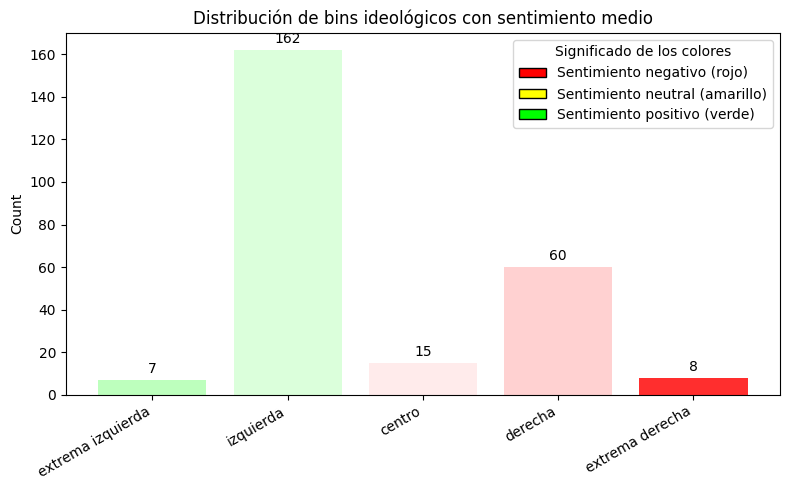

In [6]:
grafica_inicial(resumen_bins)

#### Final calculation of entropy and sentiment

##### Ideological Grouping for Entropy Calculation

To simplify the analysis and obtain a more stable and interpretable entropy, the ideological axis has been reduced to **two bins**. All **left** categories are grouped into a single bin, and the same is done for **right** categories. The **center** category is excluded from the analysis to avoid ideological ambiguities.

This reduction allows the calculation of a **binary entropy**, which is more robust and comparable across different datasets, focusing on the two ideologically opposing blocks.

The aggregated metrics for each bin are calculated using **weighted averages**, where each subcategory contributes in proportion to its number of observations. This preserves statistical consistency and prevents distortion of results when merging categories.

In [7]:
def agrupar_bins_ideologicos(stats):
    grupos = {
        "izquierda": ["izquierda", "extrema izquierda"],
        "derecha": ["derecha", "extrema derecha"]
    }

    resultado = {}

    for bin_name, categorias in grupos.items():
        total_count = 0
        weighted_sum = 0.0

        for cat in categorias:
            if cat in stats:
                n = stats[cat]["count"]
                mu = stats[cat]["mean_sentiment"]

                total_count += n
                weighted_sum += n * mu

        if total_count > 0:
            resultado[bin_name] = {
                "count": total_count,
                "mean_sentiment": weighted_sum / total_count
            }

    return resultado

def imprimir_bins_ideologicos(stats, decimales=2):
    items = list(stats.items())

    for i, (bin_name, v) in enumerate(items):
        mean = round(v["mean_sentiment"], decimales)

        print(f"    '{bin_name}': {{")
        print(f"        'count': {v['count']},")
        print(f"        'mean_sentiment': {mean}")
        print(f"    }}{',' if i < len(items) - 1 else ''}")

def entropia_shannon_por_count(stats):
    counts = [v["count"] for v in stats.values()]
    total = sum(counts)

    if total == 0:
        return 0.0

    entropia = 0.0
    for c in counts:
        if c > 0:
            p = c / total
            entropia -= p * math.log2(p)

    return entropia

def sentimiento_medio_ponderado(stats):
    total_count = sum(v['count'] for v in stats.values())
    if total_count == 0:
        return 0.0

    sent_medio = sum(v['count'] * v['mean_sentiment'] for v in stats.values()) / total_count
    return sent_medio

def polarizacion_sentimiento(stats):
    if len(stats) != 2:
        return 0.0

    counts = [v["count"] for v in stats.values()]
    if min(counts) == 0:
        return 0.0

    s = [v["mean_sentiment"] for v in stats.values()]
    return abs(s[0] - s[1]) / 2

def diversidad(stats):
    H = entropia_shannon_por_count(stats)
    S = sentimiento_medio_ponderado(stats)
    P = polarizacion_sentimiento(stats)

    D = H * (1 - P) * (1 - abs(S))
    return D

def grafica_2bins(resumen_bins):
    # Orden de los bins
    orden = ['izquierda', 'derecha']
    
    counts = [resumen_bins[b]["count"] for b in orden]
    sentiments = [resumen_bins[b]["mean_sentiment"] for b in orden]
    
    # Colores con intensidad gradual
    colors = []
    for s in sentiments:
        intensidad = min(abs(s)*2, 1.0)  # escalamos para que se note más
        if s > 0:  # verde
            colors.append((1-intensidad, 1, 1-intensidad))
        elif s < 0:  # rojo
            colors.append((1, 1-intensidad, 1-intensidad))
        else:  # amarillo para cero
            colors.append((1, 1, 0))
    
    # Gráfico de barras
    plt.figure(figsize=(6,5))
    bars = plt.bar(orden, counts, color=colors)
    
    # Etiquetas encima de las barras
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(count),
                 ha='center', va='bottom')
    
    plt.ylabel("Count")
    plt.title("Distribución de bins ideológicos con sentimiento medio")
    plt.xticks(rotation=30, ha='right')
    
    # Leyenda explicativa
    legend_elements = [
        Patch(facecolor=(1,0,0), edgecolor='k', label='Sentimiento negativo (rojo)'),
        Patch(facecolor=(1,1,0), edgecolor='k', label='Sentimiento neutral (amarillo)'),
        Patch(facecolor=(0,1,0), edgecolor='k', label='Sentimiento positivo (verde)')
    ]
    plt.legend(handles=legend_elements, title="Significado de los colores", loc='upper right')
    
    plt.tight_layout()
    plt.show()

def grafica_final(H, S, P, D):
    # Valores normalizados
    valores_radar = [H, 1 - abs(S), 1 - P]
    componentes_radar = ['H', '1-|S|', '1-P']
    
    # Radar chart
    angles = np.linspace(0, 2 * np.pi, len(componentes_radar), endpoint=False).tolist()
    valores_radar += valores_radar[:1]  # cerrar el círculo
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    
    # Radar
    ax.plot(angles, valores_radar, color='#4c72b0', linewidth=2, marker='o')
    ax.fill(angles, valores_radar, color='#4c72b0', alpha=0.25)
    
    # Ajustes del radar
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(componentes_radar, fontsize=12)
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_ylim(0,1)
    
    # D como caja aparte abajo a la derecha
    plt.figtext(0.85, 0.15, f"D = {D:.2f}", fontsize=14, color='#b85c7a', ha='center', va='center',
                bbox=dict(facecolor='pink', alpha=0.3, boxstyle='round,pad=0.5'))
    
    plt.title("Visualización de H, S, P y D", fontsize=16)
    plt.show()

In [8]:
# Procesado final
bins_def = agrupar_bins_ideologicos(resumen_bins)

# Resultados previos a la entropía
imprimir_bins_ideologicos(bins_def)

    'izquierda': {
        'count': 169,
        'mean_sentiment': 0.07
    },
    'derecha': {
        'count': 68,
        'mean_sentiment': -0.13
    }


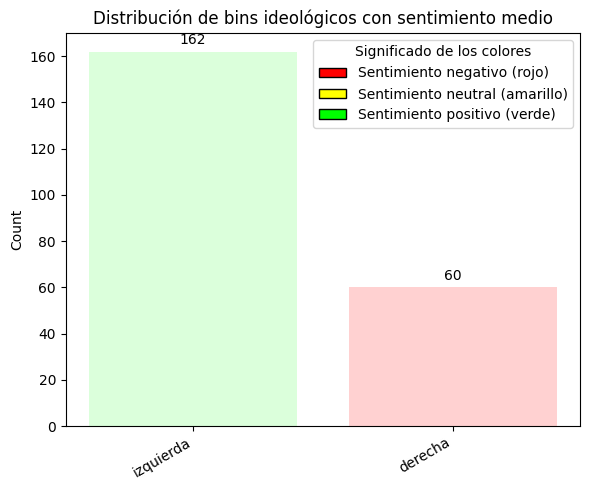

In [9]:
grafica_2bins(resumen_bins)

The following quantities are then calculated:

- **Entropy (H)**: measures the political diversity of the producer, calculated from the distribution of content between the two ideological bins (left and right). High values indicate a more balanced attention between both sides.

- **Weighted average sentiment (S)**: measures consumer activation and is obtained as the mean sentiment, weighted by the number of observations in each bin. This metric allows identifying cases where both political currents show similar sentiments. When \(|S| \approx 1\), the value is interpreted negatively, as it indicates a systematic attempt to influence or manipulate the reader, regardless of the sign.

- **Sentiment polarization (P)**: quantifies the emotional disagreement between the bins. It reaches its maximum value (1) when one bin has an average sentiment of \(+1\) and the other \(-1\), reflecting extreme polarization. It is independent of the relative counts of each bin.

In this way, the maximum diversity value is obtained when each bin has the same number of references, and the mean sentiment of each bin is 0.0. In this case, entropy is maximal, there is no sentiment manipulation, nor polarization. In the opposite case, we have the minimum value, i.e., zero diversity. That is, a diversity metric is obtained that combines both the producer and consumer aspects, making it more objective and meaningful for both parties.

In [15]:
H = entropia_shannon_por_count(bins_def)
S = sentimiento_medio_ponderado(bins_def)
P = polarizacion_sentimiento(bins_def)
D = diversidad(bins_def)

print(f"H: {round(H,4)}")
print(f"S: {round(S,4)}")
print(f"P: {round(P,4)}")
print(f"D: {round(D,4)}")

H: 0.8647
S: 0.0151
P: 0.1001
D: 0.7665


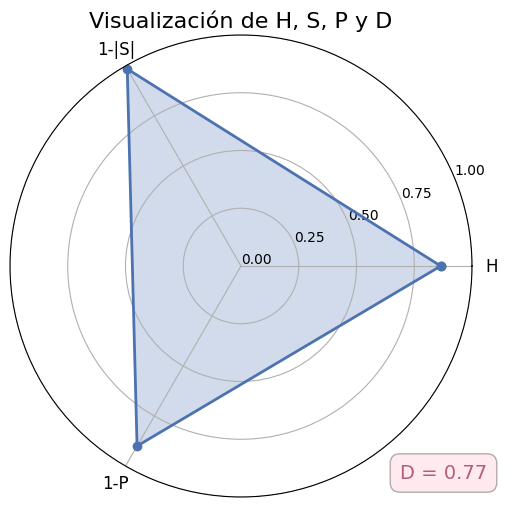

In [16]:
grafica_final(H, S, P, D)